In [1]:
import sys
sys.path.insert(0, "../..")

In [2]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split

from logistic_regression import LogisticRegression
from extrapolation import *
from experiments import RestartingExperiment

In [2]:
device = "cuda"

X = []
with open("../madelon_train.data") as f:
    for line in f:
        X.append([float(x) for x in line.split()])
X = np.array(X)
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
X = torch.tensor(X, device=device)
with open("../madelon_train.labels") as f:
    y = [int(x) for x in f]
y = torch.tensor(y, device=device)
X.shape, y.shape

(torch.Size([2000, 501]), torch.Size([2000]))

In [3]:
np.random.seed(2020)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

$\tau = 10^2$

In [4]:
model = LogisticRegression(X_train, y_train, 1e2, device=device)

In [5]:
model.fit(-1, max_iter=50500)

In [6]:
len(model.log)

50501

In [7]:
preds = model.predict(X_test)
torch.mean((preds == y_test).double())

tensor(0.5750, device='cuda:0', dtype=torch.float64)

In [8]:
model.new_objective(X_train.cpu(), y_train.cpu(), 1e2, device="cpu")

In [9]:
experiment = RestartingExperiment(model, 5, device="cpu")

In [10]:
experiment.run_method("RRE+QR", RRE, 10000, method_kwargs={"qr": True})

In [11]:
experiment.run_method("RNA", RNA, 10000, {"lambda_range": (1e-15, 1e-2), "linesearch": False, "norm": False})

In [12]:
experiment.run_method("RNA+norm", RNA, 10000, {"lambda_range": (1e-15, 1e-2), "linesearch": False})

In [13]:
experiment.run_method("RNA+ls", RNA, 10000, {"lambda_range": (1e-15, 1e-2), "linesearch": True})

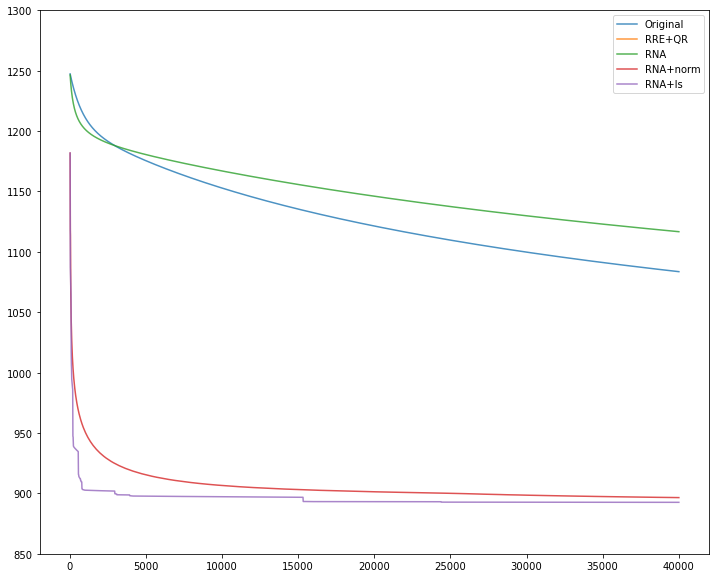

In [18]:
experiment.plot_values(n=40000, figsize=(12, 10), ylim=(850, 1300))

In [19]:
experiment.value_logs["RRE+QR"][:15]

[7063.800140178014,
 138314.60098956298,
 129110.90162112899,
 128830.44752671348,
 127339.89184914448,
 126278.92246842256,
 114348.1551061672,
 160226.44675177298,
 157772.55703146444,
 157492.8761317198,
 672807.9394259459,
 673058.6718687309,
 672961.2853819884,
 671240.3895839062,
 671640.2158798681]

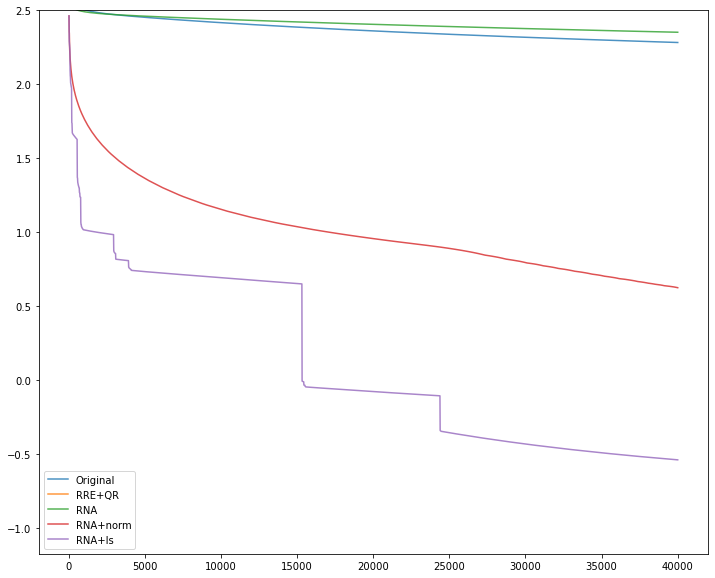

In [15]:
experiment.plot_log_diff(n=40000, figsize=(12, 10), ylim=(None, 2.5))

In [20]:
experiment.save("madelon-restarts-1e2.p")